In [128]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import scipy.io.wavfile as wf
from glob import glob
from collections import deque


#import audiofile

In [129]:
def plot_sin(sample, t = np.array([])):
    plt.figure()
    plt.title("")
    plt.xlabel("t(s)")
    plt.ylabel("Amplitude")
    if len(t) == 0:
        plt.plot(sample)
    else:
        plt.plot(t, sample)

## 1.1

### 1.1.1

In [130]:
def create_sine_wave(f, A, fs, N):
    sampling = np.arange(0, N/fs,1/fs)
    sin_samples =  np.sin(2 * np.pi * sampling * f)
    return sampling, A * sin_samples

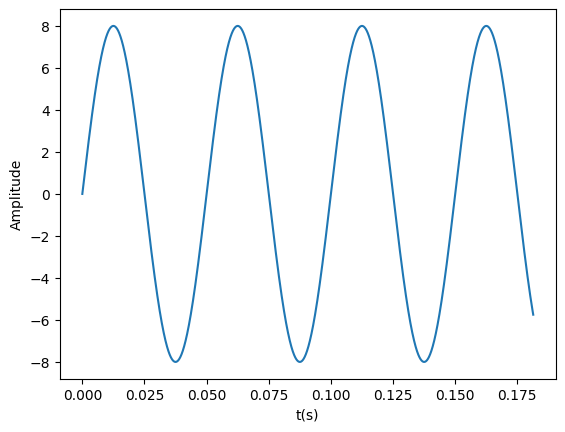

In [131]:
fs = 44.1 * 1000
N = 8000
f = 20
amplitude = 8

t, samples = create_sine_wave(f, amplitude, fs, N)
plot_sin(samples, t)

### 1.1.2

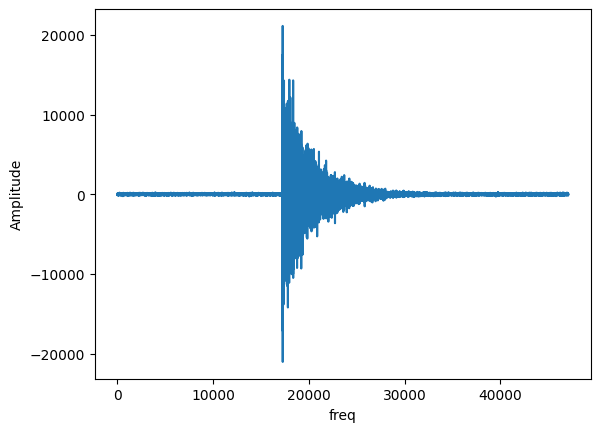

In [132]:
def read_wavefile(path):
    return wf.read(path)

_, data = read_wavefile("LocateClaps/M2_180.wav")

plt.figure()
plt.title("")
plt.xlabel("freq")
plt.ylabel("Amplitude")
plt.plot(data)

Find all files ending in `.wav`

In [133]:

LocateClaps = "./LocateClaps"
files = glob(f"{LocateClaps}/*.wav")


## 1.2

### 1.2.1

See the following documentation : [Collections `deque`](https://docs.python.org/3/library/collections.html#collections.deque)

In [ ]:
def create_ringbuffer(maxlen):
    return deque(maxlen=maxlen)


def plot_buffer_content(buffer):
    plot_sin(buffer)


### 1.2.2

0.1
0.15
0.1
0.15


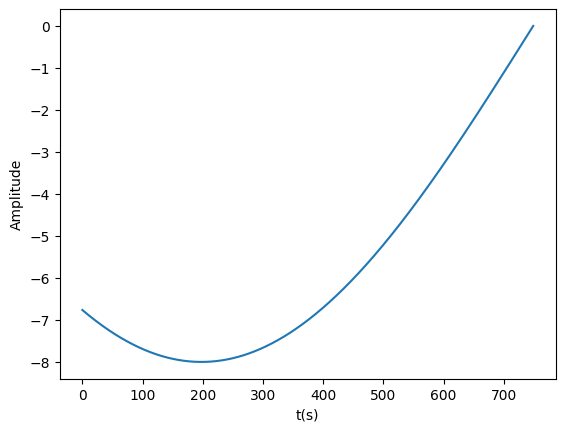

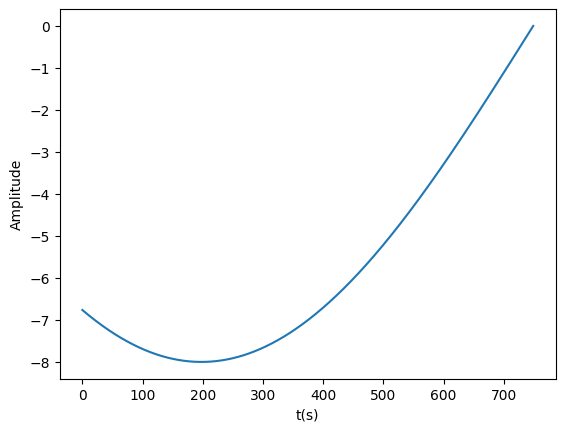

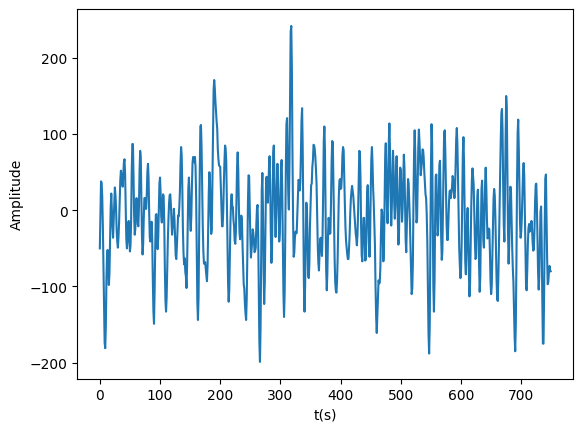

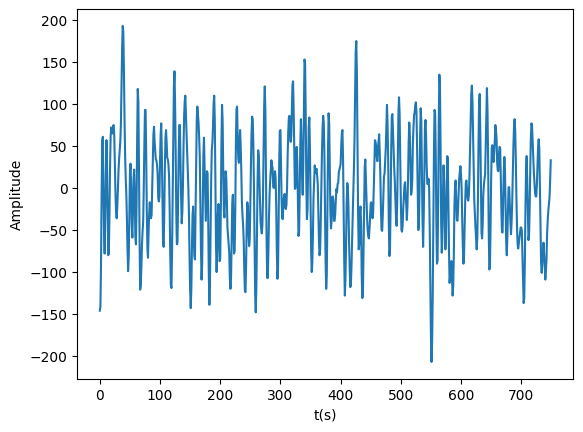

In [ ]:
maxlen = 750
buffer = create_ringbuffer(maxlen)

# TODO : Change the graph x time


for i, sample in enumerate(samples):
    buffer.append(sample)
    if i == int(0.1 * fs):
        plot_buffer_content(buffer)
    elif i == int(0.15 * fs) :
        plot_buffer_content(buffer)
        

# When using our signal wave from 1.1.1, and looking at the times 0.1 & 0.01, we notice the exact same waveform.

buffer = create_ringbuffer(maxlen)
_, data = read_wavefile("LocateClaps/M2_180.wav")

for i, sample in enumerate(data):
    buffer.append(sample)
    if i == int(0.1 * fs):
        print(i* 1/fs)
        plot_buffer_content(buffer)
    elif i == int(0.15 * fs) :
        print(i* 1/fs)
        plot_buffer_content(buffer)
        

## 1.3

#### 1.3.1

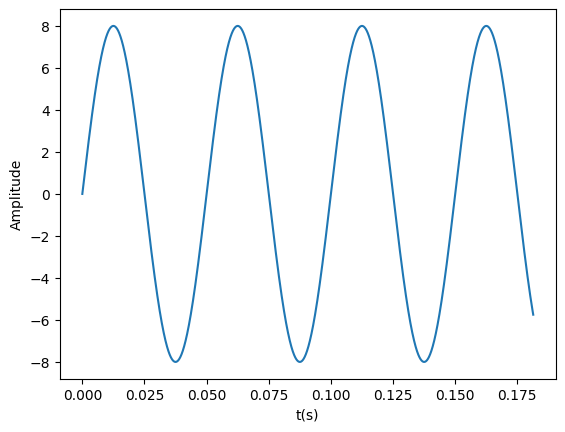

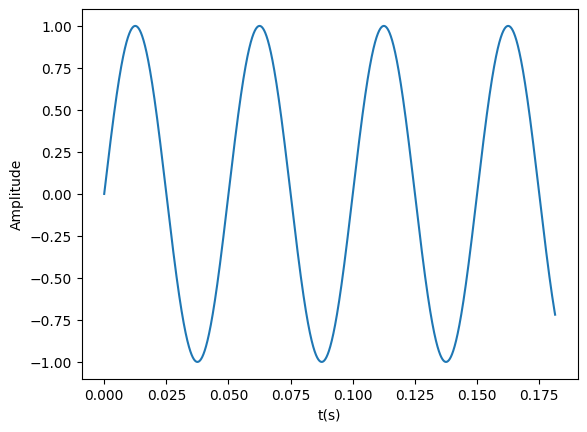

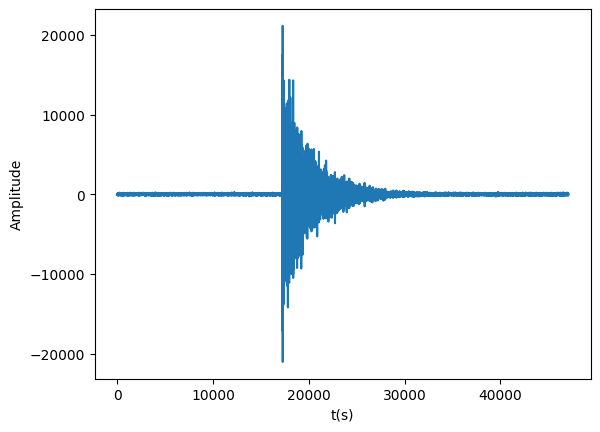

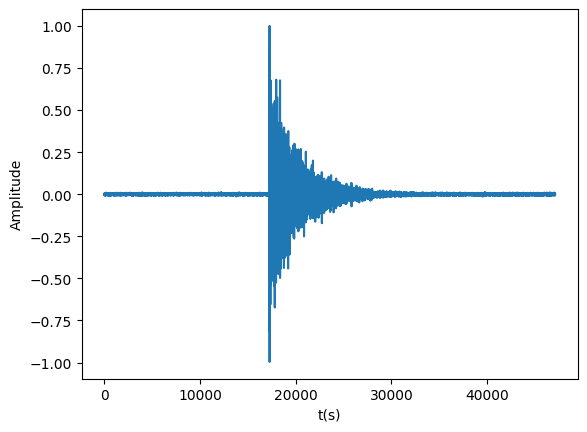

In [ ]:
def get_max(s):
    max = float('-inf')
    for i in s:
        if i > max:
            max = i
    return max


def normalise(s):
    max = get_max(s)
    return s / max

plot_sin(samples, t)
plot_sin(normalise(samples), t)


plot_sin(data)
plot_sin(normalise(data))

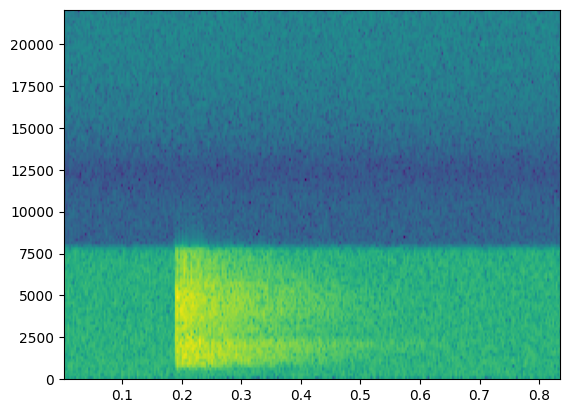

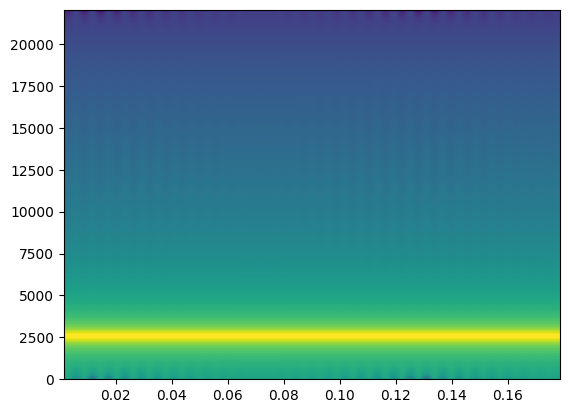

In [ ]:
# Let's first take an example:
fs = 44.1 * 1000
N = 8000
f = 2500
amplitude = 8
plt.figure()
t, samples = create_sine_wave(f, amplitude, fs, N)
x = plt.specgram(normalise(samples), Fs=fs)


# Using that example, let's do the same for one of the audio file :)
f, data = read_wavefile("LocateClaps/M2_0.wav")
x = plt.specgram(normalise(data), Fs=f)
